In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import Ridge, RidgeCV



In [2]:
df_train = pd.read_csv("../data/train.csv")
df_test = pd.read_csv("../data/test.csv")

X_train = df_train.drop(columns=["SalePrice"])
y_train = df_train["SalePrice"]

In [3]:
df_train.describe()
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
# Print numeric columns
numeric_looking_columns = X_train.select_dtypes(include=np.number).columns.tolist()
print(numeric_looking_columns)

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


In [5]:
drop_features = ["Id"]
numeric_features = [
    "BedroomAbvGr",
    "KitchenAbvGr", 
    "LotFrontage",
    "LotArea",
    "OverallQual",
    "OverallCond",
    "YearBuilt",
    "YearRemodAdd",
    "MasVnrArea",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "1stFlrSF",
    "2ndFlrSF",
    "LowQualFinSF",
    "GrLivArea",
    "BsmtFullBath",
    "BsmtHalfBath",
    "FullBath",
    "HalfBath",
    "TotRmsAbvGrd",
    "Fireplaces",
    "GarageYrBlt",
    "GarageCars",
    "GarageArea",
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch",
    "PoolArea",
    "MiscVal",
    "YrSold",
]

In [6]:
set(numeric_looking_columns) - set(numeric_features) - set(drop_features)

{'MSSubClass', 'MoSold'}

In [7]:
ordinal_features_reg = [
    "ExterQual",
    "ExterCond",
    "BsmtQual",
    "BsmtCond",
    "HeatingQC",
    "KitchenQual",
    "FireplaceQu",
    "GarageQual",
    "GarageCond",
    "PoolQC",
]
ordering = [
    "Po",
    "Fa",
    "TA",
    "Gd",
    "Ex",
]  # if N/A it will just impute something, per below
ordering_ordinal_reg = [ordering] * len(ordinal_features_reg)
ordering_ordinal_reg

[['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex']]

In [8]:
# Ordinal Features
ordinal_features_oth = [
    "BsmtExposure",
    "BsmtFinType1",
    "BsmtFinType2",
    "Functional",
    "Fence",
]
ordering_ordinal_oth = [
    ['NA', 'No', 'Mn', 'Av', 'Gd'],
    ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    ['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ'],    
    ['NA', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']
]

In [9]:
# Categorical Features
categorical_features = list(
    set(X_train.columns)
    - set(numeric_features)
    - set(ordinal_features_reg)
    - set(ordinal_features_oth)    
    - set(drop_features)
)
categorical_features

['SaleType',
 'SaleCondition',
 'Exterior1st',
 'Street',
 'Neighborhood',
 'RoofStyle',
 'PavedDrive',
 'Utilities',
 'Condition1',
 'Exterior2nd',
 'MiscFeature',
 'MasVnrType',
 'MoSold',
 'BldgType',
 'LotShape',
 'Alley',
 'MSZoning',
 'CentralAir',
 'LandContour',
 'LandSlope',
 'Heating',
 'HouseStyle',
 'LotConfig',
 'GarageFinish',
 'Condition2',
 'Foundation',
 'Electrical',
 'RoofMatl',
 'MSSubClass',
 'GarageType']

In [10]:
# Creating Transformers
from sklearn.compose import ColumnTransformer, make_column_transformer

numeric_transformer = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

ordinal_transformer_reg = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(categories=ordering_ordinal_reg),
)

ordinal_transformer_oth = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(categories=ordering_ordinal_oth),
)

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore"),
)

preprocessor = make_column_transformer(
    ("drop", drop_features),
    (numeric_transformer, numeric_features),
    (ordinal_transformer_reg, ordinal_features_reg),
    (ordinal_transformer_oth, ordinal_features_oth),
    (categorical_transformer, categorical_features),
)

In [11]:
preprocessor.fit(X_train) # Calling fit to examine all the transformers.
X_train.describe()
X_train.info()

# preprocessor
# preprocessor.named_transformers_.keys()
# preprocessor.named_transformers_

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [12]:
ohe_columns = list(
    preprocessor.named_transformers_["pipeline-4"]
    .named_steps["onehotencoder"]
    .get_feature_names_out(categorical_features)
)
new_columns = numeric_features + ordinal_features_reg + ordinal_features_oth + ohe_columns

In [13]:
# Apply transformation
X_train_enc = pd.DataFrame(
    preprocessor.transform(X_train), index=X_train.index, columns=new_columns
)
X_train_enc.head()

,BedroomAbvGr,KitchenAbvGr,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,MSSubClass_160,MSSubClass_180,MSSubClass_190,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_missing
0,0.163779,-0.211454,-0.220875,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.514104,0.575425,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.163779,-0.211454,0.460320,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.570750,1.171992,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.163779,-0.211454,-0.084636,0.073480,0.651479,-0.517200,0.984752,0.830215,0.325915,0.092907,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.163779,-0.211454,-0.447940,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.570750,-0.499274,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.390023,-0.211454,0.641972,0.375148,1.374795,-0.517200,0.951632,0.733308,1.366489,0.463568,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [14]:
X_train.shape

(1460, 80)

In [15]:
# Notice the change in features due to transformations
X_train_enc.shape

# columns = X_train_enc.columns.tolist()
# print(columns)

(1460, 262)

In [16]:
# TODO Mode Models to explore

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

regr = RandomForestRegressor(max_depth=10, random_state=0)
lr_pipe = make_pipeline(preprocessor, regr)
# pd.DataFrame(cross_validate(lr_pipe, X_train, y_train, cv=10, return_train_score=True))

param_grid = {
    'randomforestregressor__n_estimators': [150, 200],  # Number of trees in the forest
    'randomforestregressor__max_depth': [10, 15]  # Maximum depth of the tree
}

# Set up GridSearchCV
grid_search = GridSearchCV(lr_pipe, param_grid, cv=10, return_train_score=True)

# Fit the model with grid search
grid_search.fit(X_train, y_train)

# Convert the results into a DataFrame
results = pd.DataFrame(grid_search.cv_results_)

# Print the results
print(results[['param_randomforestregressor__n_estimators', 'param_randomforestregressor__max_depth']])
 

  param_randomforestregressor__n_estimators  \
0                                       150   
1                                       200   
2                                       150   
3                                       200   

  param_randomforestregressor__max_depth  
0                                     10  
1                                     10  
2                                     15  
3                                     15  


In [17]:
# Fit the model with grid search
grid_search.fit(X_train, y_train)

# Best parameter set
best_params = grid_search.best_params_

# Best average test score
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Average Test Score:", best_score)


Best Parameters: {'randomforestregressor__max_depth': 15, 'randomforestregressor__n_estimators': 200}
Best Average Test Score: 0.8653958327648317


In [18]:
# Using Ridge Regresion model
###TODO Split 8 performs poorly. Why?
lr_pipe = make_pipeline(preprocessor, Ridge())
pd.DataFrame(cross_validate(lr_pipe, X_train, y_train, cv=10, return_train_score=True))

,fit_time,score_time,test_score,train_score
0,0.290998,0.074565,0.886083,0.910672
1,0.414003,0.027645,0.891826,0.910281
2,0.414528,0.060758,0.884051,0.909535
3,0.444895,0.031296,0.789709,0.916847
4,0.462313,0.038702,0.877815,0.909918
5,0.446871,0.038547,0.838072,0.914768
6,0.439328,0.043693,0.855152,0.912257
7,0.446391,0.043848,0.854245,0.912889
8,0.443735,0.038004,0.550310,0.922023
9,0.425549,0.022282,0.889359,0.910937


In [20]:
# Exploring hyperparameter alpha
# Could use other methods such as GridSearch etc..

alphas = 10.0 ** np.arange(-5, 5, 1)
train_scores = []
cv_scores = []
for alpha in alphas:
    lr = make_pipeline(preprocessor, Ridge(alpha=alpha))
    results = cross_validate(lr, X_train, y_train, return_train_score=True)
    train_scores.append(np.mean(results["train_score"]))
    cv_scores.append(np.mean(results["test_score"]))

Text(0, 0.5, 'score')

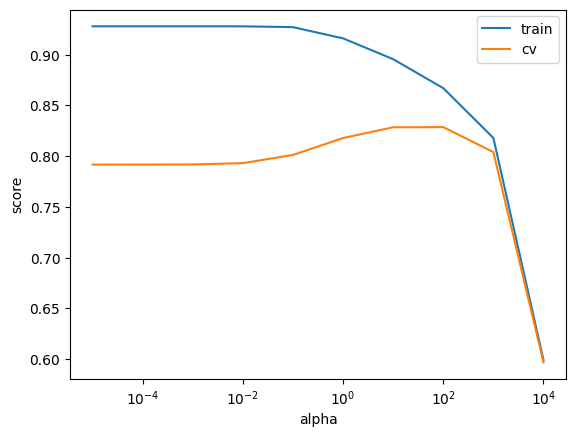

In [21]:
plt.semilogx(alphas, train_scores, label="train")
plt.semilogx(alphas, cv_scores, label="cv")
plt.legend()
plt.xlabel("alpha")
plt.ylabel("score")

In [22]:
best_alpha = alphas[np.argmax(cv_scores)]
best_alpha

100.0

In [23]:
# Using RidgeCV Model
ridgecv_pipe = make_pipeline(preprocessor, RidgeCV(alphas=alphas))
pd.DataFrame(cross_validate(ridgecv_pipe, X_train, y_train, cv=10, return_train_score=True))

,fit_time,score_time,test_score,train_score
0,0.351398,0.004877,0.891040,0.889441
1,0.601739,0.013680,0.899992,0.887879
2,0.453904,0.028789,0.886835,0.888918
3,0.603136,0.010341,0.788990,0.897524
4,0.589077,0.006013,0.867482,0.889929
5,0.627604,0.006029,0.879009,0.890100
6,0.596587,0.006086,0.860289,0.891809
7,0.608294,0.006067,0.863883,0.891881
8,0.586638,0.005742,0.568039,0.912170
9,0.588077,0.012845,0.887496,0.889953


In [24]:
alphas = 10.0 ** np.arange(-5, 5, 1)
lr_tuned = make_pipeline(preprocessor, Ridge(alpha=best_alpha))
lr_tuned.fit(X_train, y_train)
lr_preds = lr_tuned.predict(df_test)
lr_preds[:10]

array([107345.55319665, 163801.4761478 , 173182.07593043, 188637.79438005,
       198995.52819943, 170106.73856458, 179655.58894534, 165012.55259229,
       201485.5562097 , 112705.77374417])

In [25]:
# Lowest and highest predicted housing price
lr_preds.max(), lr_preds.min()

(597329.6587585986, 15924.63756156867)

In [26]:
# See what features have the highest coefficients according to model
### TODO: Do these make sense? Discuss.

ohe_columns = list(
    preprocessor.named_transformers_["pipeline-4"]
    .named_steps["onehotencoder"]
    .get_feature_names_out(categorical_features)
)
new_columns = numeric_features + ordinal_features_reg + ordinal_features_oth + ohe_columns

df = pd.DataFrame(
    data={
        "features": new_columns,
        "coefficients": lr_tuned.named_steps["ridge"].coef_,
    }
)

df.sort_values("coefficients",ascending=False)

,features,coefficients
4,OverallQual,14487.483519
16,GrLivArea,11948.301942
97,Neighborhood_NridgHt,10247.740991
96,Neighborhood_NoRidge,9575.439572
14,2ndFlrSF,8366.481271
...,...,...
232,RoofMatl_ClyTile,-4064.688585
182,LandContour_Bnk,-4903.718393
89,Neighborhood_Gilbert,-5132.587921
86,Neighborhood_CollgCr,-5384.371401


In [27]:
# MSE
lr_tuned.predict(X_train)
preds = lr_tuned.predict(X_train)
np.mean((y_train - preds) ** 2) 


848935883.1762003

In [28]:
# Can also call a sklearn function
from sklearn.metrics import mean_squared_error

mean_squared_error(y_train, preds)

848935883.1762003

In [29]:
# MSE looks huge and unreasonable. There is an error of ~$700 Million
# Let's use RMSE instead
np.sqrt(mean_squared_error(y_train, lr_tuned.predict(X_train)))

29136.504306045368

Text(0, 0.5, 'predicte price')

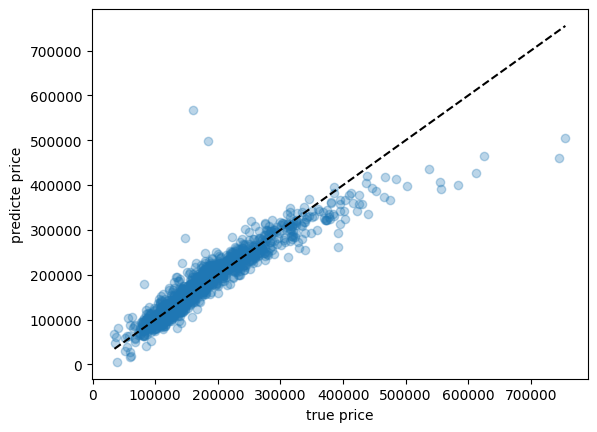

In [30]:
# Draw plot of predicted versus true price
plt.scatter(y_train, lr_tuned.predict(X_train), alpha=0.3)
grid = np.linspace(y_train.min(), y_train.max(), 1000)
plt.plot(grid, grid, "--k")
plt.xlabel("true price")
plt.ylabel("predicte price")

(array([ 5.,  0.,  5.,  6.,  6.,  7., 32., 29., 23., 35., 59., 67., 73.,
        92., 89., 91., 62., 60., 57., 73., 67., 54., 45., 33., 30., 31.,
        31., 33., 26., 23., 17., 19., 18., 18., 14., 11.,  5.,  8., 13.,
        12., 10.,  6.,  6.,  5.,  1.,  3.,  5.,  6.,  5.,  4.,  3.,  2.,
         3.,  1.,  3.,  1.,  2.,  2.,  0.,  2.,  0.,  1.,  1.,  0.,  1.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  2.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.]),
 array([ 34900.,  42101.,  49302.,  56503.,  63704.,  70905.,  78106.,
         85307.,  92508.,  99709., 106910., 114111., 121312., 128513.,
        135714., 142915., 150116., 157317., 164518., 171719., 178920.,
        186121., 193322., 200523., 207724., 214925., 222126., 229327.,
        236528., 243729., 250930., 258131., 265332., 272533., 279734.,
        286935., 294136., 301337., 308538., 315739., 322940., 330141.,
        

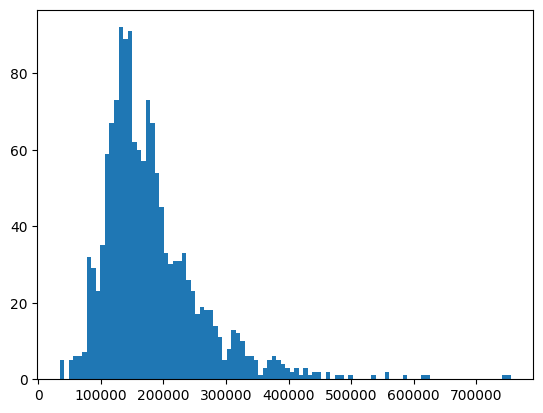

In [31]:
# Plot histogram of predictions
plt.hist(y_train, bins=100)

In [32]:
# The absolute percent error:

pred_train = lr_tuned.predict(X_train)
percent_errors = (pred_train - y_train) / y_train * 100.0
np.abs(percent_errors)


0        0.426190
1        7.876896
2        3.102742
3       36.029445
4       17.808726
          ...    
1455     5.320100
1456     2.713801
1457     6.464129
1458    10.890364
1459     5.999828
Name: SalePrice, Length: 1460, dtype: float64

In [33]:
# Using MAPE

from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(y_train, pred_train)

0.10024833575346258

In [34]:
### TODO 
# Use different scoring function for cross validate
# Use different models
# Apply hyperparameter optimization
# Compare models